# Lab 6 - Denoising

In this lab we will use denoising to clean up some noisy recordings. We will use the following sounds:

Speech in a room: [https://drive.google.com/uc?export=download&id=1g5nbBpNbCjqs8cSoW0Lb-owe15tswDwW ]

ATC: [https://drive.google.com/uc?export=download&id=1fh5iL5qRj3-PUP_sG5-QE5DofACY_Hr5 ]

Speech with wind: [https://drive.google.com/uc?export=download&id=1g7TIkLpnWDFNUQYgCqIUoSOkk5EIK16_ ]



## Part 1. Cleaning up the sounds

Let’s start by cleaning up these sounds as best as we can. We will do a straightforward magnitude spectral subtraction. For all of these sounds there is only noise in the first few seconds of the recording so that you can learn a noise profile from there. Do the following:
Perform an STFT of the recordings

- Estimate the magnitude spectrum of the noise from the beginning of the recording
    - It’s up to you to figure out how many seconds to use (hint: look at the spectrogram)

- Perform spectral subtraction by subtracting that spectrum from the input’s magnitude STFT
    - Remember to clip any resulting negative values to zero
    - Try to find how much of the noise to subtract so that the output looks good

- Use the original signal’s phase to convert back to a time series.

Make a note of which examples sound the best and are easier to work with. Try to explain why.
At this point some of the outputs will exhibit “musical noise”. To minimize its effects apply a median filter on the denoised magnitude spectrogram to make it sound better (hint: ```scipy.signal.medfilt2```). How big should the median window be? Try different values and find which work best.


/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  # This is added back by InteractiveShellApp.init_path()


room original


atc original


wind original


room filtered


atc filtered


wind filtered


atc minimized musical noise


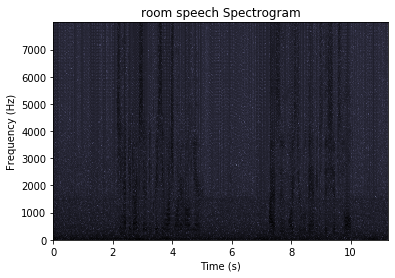

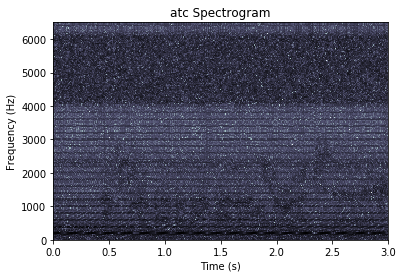

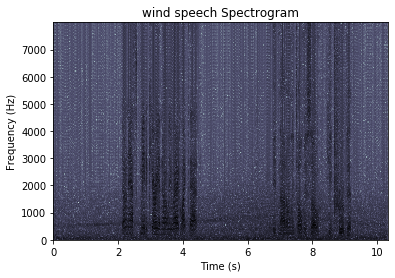

In [23]:
# YOUR CODE HERE
import numpy as np
import scipy.io.wavfile
import scipy.signal
import scipy
import math
import matplotlib.pyplot as plt

room_sr, room_audio = scipy.io.wavfile.read('data/Lab6/room-speech.wav')
atc_sr, atc_audio = scipy.io.wavfile.read('data/Lab6/aircomm.wav')
wind_sr, wind_audio = scipy.io.wavfile.read('data/Lab6/wind-speech.wav')

def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

sound(room_audio, room_sr, label="room original")
sound(atc_audio, atc_sr, label="atc original")   
sound(wind_audio, wind_sr, label="wind original")

def stft(input_sound, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    input_copy = input_sound
    while(len(input_copy)%dft_size != 0):
        input_copy = np.append(input_copy, 0)
        
    frames = []
    frame_idx = dft_size
    while(frame_idx <= len(input_copy)):
        frame = input_copy[(frame_idx-dft_size):frame_idx]
        frame = np.append(frame, np.zeros(zero_pad))
        frame *= window
        frames.append(frame)
        frame_idx += hop_size
        
    dfts = np.fft.rfft(frames[0])
    for i in range(1, len(frames)):
        dfts = np.vstack((dfts, np.fft.rfft(frames[i])))

    # Return a complex-valued spectrogram (frequencies x time)
    return dfts

def plot_spec(input_sound, input_sr, stft_out, dft_size, zero_pad, audio_type):
    time_range = np.linspace(0, float(len(input_sound))/float(input_sr), len(stft_out))
    max_freq = np.max(np.fft.fftfreq(input_sound.size, 1.0/input_sr))
    freq_range = (np.linspace(0, max_freq, num=int(((dft_size+zero_pad)/2+1))))
    stft_out = np.abs(np.transpose(stft_out[:-1,:-1].real))**0.5
    if audio_type == "room speech":
        plt.figure(1)
    elif audio_type == "atc":
        plt.figure(2)
    elif audio_type == "wind speech":
        plt.figure(3)
    elif audio_type == "wind denoised":
        plt.figure(4)
    plt.pcolormesh(time_range, freq_range, np.log10(stft_out)*10, cmap='bone_r')
    plt.title(audio_type + ' Spectrogram')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

def istft( stft_output, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    input_size = len(stft_output)
    stft_out = stft_output
    iffts = np.fft.ifft(stft_out[0], dft_size+zero_pad)
    iffts *= window
    for i in range(1, input_size):
        frame = np.fft.ifft(stft_out[i], dft_size+zero_pad)
        frame *= window
        iffts = np.vstack((iffts, frame))
    
    x = np.zeros(dft_size + zero_pad + (input_size-1)*hop_size)
    for i in range(len(iffts)):
        x[i*hop_size:i*hop_size+dft_size+zero_pad] += iffts[i].real
    # Return reconstructed waveform
    return x

room_stft = stft(room_audio, 256, 64, 128, 1)
plot_spec(room_audio, room_sr, room_stft, 256, 128, "room speech")
atc_stft = stft(atc_audio, 256, 64, 128, 1)
plot_spec(atc_audio, atc_sr, atc_stft, 256, 128, "atc")
wind_stft = stft(wind_audio, 256, 64, 128, 1)
plot_spec(wind_audio, wind_sr, wind_stft, 256, 128, "wind speech")

room_noise = np.linalg.norm(room_stft[0:(int((25000/len(room_audio))*len(room_stft))+1)], axis=0)
atc_noise = np.linalg.norm(atc_stft[0:(int((5000/len(atc_audio))*len(atc_stft))+1)], axis=0)
wind_noise = np.linalg.norm(wind_stft[0:(int((30000/len(wind_audio))*len(wind_stft))+1)], axis=0)

room_sub = np.zeros(np.shape(room_stft), dtype='complex')
for i in range(len(room_sub)):
    for j in range(len(room_sub[0])):
        room_sub[i,j] = (np.abs(room_stft[i,j])-(0.18*room_noise[j])).clip(min=0)*np.exp(1j*np.angle(room_stft[i,j]))
atc_sub = np.zeros(np.shape(atc_stft), dtype='complex')
for i in range(len(atc_sub)):
    for j in range(len(atc_sub[0])):
        atc_sub[i,j] = (np.abs(atc_stft[i,j])-(0.25*atc_noise[j])).clip(min=0)*np.exp(1j*np.angle(atc_stft[i,j]))
wind_sub = np.zeros(np.shape(wind_stft), dtype='complex')
for i in range(len(wind_sub)):
    for j in range(len(wind_sub[0])):
        wind_sub[i,j] = (np.abs(wind_stft[i,j])-(0.25*wind_noise[j])).clip(min=0)*np.exp(1j*np.angle(wind_stft[i,j]))

room_filtered = istft(room_sub, 256, 64, 128, 1)
atc_filtered = istft(atc_sub, 256, 64, 128, 1)
wind_filtered = istft(wind_sub, 256, 64, 128, 1)

sound(room_filtered, room_sr, label="room filtered")
sound(atc_filtered, atc_sr, label="atc filtered")
sound(wind_filtered, wind_sr, label="wind filtered")

#the room speech and wind speech samples are easiest to work with and sound the best because the noise is mostly
#in the lower frequencies. the atc sample is harder to denoise because of the noise being around the same
#frequencies as the voice, resulting in musical noise

atc_sub = np.zeros(np.shape(atc_stft))
for i in range(len(atc_sub)):
    for j in range(len(atc_sub[0])):
        atc_sub[i,j] = (np.abs(atc_stft[i,j]) - (0.25 * atc_noise[j])).clip(min=0)
atc_medfilt = scipy.signal.medfilt2d(atc_sub, 3)
atc_filt = np.zeros(np.shape(atc_stft), dtype='complex')
for i in range(len(atc_filt)):
    for j in range(len(atc_filt[0])):
        atc_filt[i,j] = atc_medfilt[i,j] * np.exp(1j * np.angle(atc_stft[i,j]))
        
atc_filtered = istft(atc_filt, 256, 64, 128, 1)
sound(atc_filtered, atc_sr, label="atc minimized musical noise")



## Part 2. Implement a Voice Activity Detector (VAD)


For the last sound we have an evolving noise profile, which causes problems since our noise description from the first two seconds isn’t accurate throughout. Because we’re lazy we want to automatically update the noise model and not to select it manually. To do so we need a VAD that lets us know when to gather noise statistics and when to denoise. Do the following:

- Take the square of the input waveform and lowpass filter it (a lot) to get an energy level over time
    - Experiment with the cutoff frequency so that you get a smooth energy-looking function
- Set a threshold over which we seem to have speech in the input
- Implement a real-time spectral subtraction denoiser
    - If an input frame is under threshold, it is noise
    - Keep track of the last few noise frames and their average amplitude will be your noise spectrum
    - If an input is over the threshold it is speech
    - Once you encounter speech perform spectral subtraction with the current noise estimate

wind speech filtered


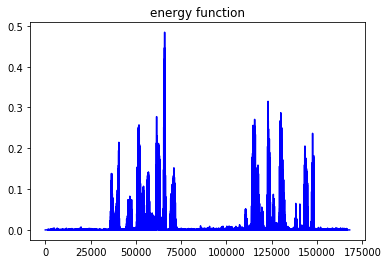

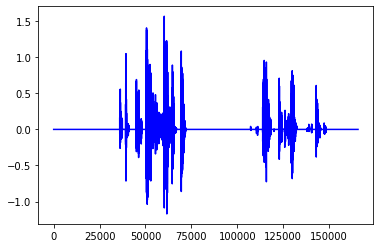

In [36]:
# YOUR CODE HERE
lowpass_filt = scipy.signal.firwin(numtaps=len(wind_stft), cutoff=1000, pass_zero='lowpass', fs=wind_sr)
energy = np.abs(scipy.signal.convolve(wind_audio**2, lowpass_filt))
plt.title("energy function")
plt.plot(energy, 'b-')
energy_stft = stft(energy, 256, 64, 128, 1)
wind_sub = np.zeros(np.shape(wind_stft), dtype='complex')
noise_mag = np.linalg.norm(wind_stft[0:5], axis=0)

for i in range(len(wind_audio)):
    if energy[i] < 0.01: #noise
        for j in range(len(wind_sub[0])):
            wind_sub[frame,j] = 0
    else: #speech
        frame = int((1.0*i)/len(wind_audio)*len(wind_stft))
        for j in range(len(wind_sub[0])):
            wind_sub[frame,j] = (np.abs(wind_stft[frame,j])-(0.25*noise_mag[j])).clip(min=0)*np.exp(1j*np.angle(wind_stft[frame,j]))

wind_filtered = istft(wind_sub, 256, 64, 128, 1)
sound(wind_filtered, wind_sr, label="wind speech filtered")
plt.figure(5)
plt.plot(np.arange(len(wind_filtered)), wind_filtered, 'b-')